In [46]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:
train_df = pd.read_csv("../data/processed/train_clean.csv")
test_df  = pd.read_csv("../data/processed/test_clean.csv")

TRAIN_IMG_DIR = "../data/images/train"
TEST_IMG_DIR  = "../data/images/test"


In [5]:
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [6]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()   # removes final classification layer
resnet = resnet.to(device)
resnet.eval()


C:\Users\mohit\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mohit\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
def extract_image_features(df, img_dir):
    features = []
    ids = []

    missing = 0

    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df)):
            img_path = os.path.join(img_dir, f"{row['id']}.png")

            if not os.path.exists(img_path):
                missing += 1
                continue

            image = Image.open(img_path).convert("RGB")
            image = img_transform(image).unsqueeze(0).to(device)

            embedding = resnet(image)
            embedding = embedding.cpu().numpy().flatten()

            features.append(embedding)
            ids.append(row["id"])

    print(f"Skipped {missing} missing images")
    return np.array(features), ids

train_img_features, train_ids = extract_image_features(
    train_df, TRAIN_IMG_DIR
)

print(train_img_features.shape)



100%|████████████████████████████████████████████████████████████████████████████| 16207/16207 [07:05<00:00, 38.13it/s]

Skipped 0 missing images
(16207, 512)


In [8]:
test_img_features, test_ids = extract_image_features(
    test_df, TEST_IMG_DIR
)

print(test_img_features.shape)


100%|██████████████████████████████████████████████████████████████████████████████| 5393/5393 [02:19<00:00, 38.65it/s]

Skipped 0 missing images
(5393, 512)


In [9]:
os.makedirs("../data/embeddings", exist_ok=True)

np.save("../data/embeddings/train_img_features.npy", train_img_features)
np.save("../data/embeddings/test_img_features.npy", test_img_features)


In [10]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [11]:
# Load cleaned tabular data
train_df = pd.read_csv("../data/processed/train_clean.csv")
test_df  = pd.read_csv("../data/processed/test_clean.csv")

# Load image embeddings
train_img = np.load("../data/embeddings/train_img_features.npy")
test_img  = np.load("../data/embeddings/test_img_features.npy")


In [12]:
# Convert image embeddings to DataFrame
train_img_df = pd.DataFrame(train_img)
train_img_df["id"] = train_df.iloc[:len(train_img)]["id"].values

test_img_df = pd.DataFrame(test_img)
test_img_df["id"] = test_df.iloc[:len(test_img)]["id"].values


In [13]:
train_df = train_df.merge(train_img_df, on="id", how="inner")
test_df  = test_df.merge(test_img_df, on="id", how="inner")


In [14]:
tabular_features = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement", "lat", "long",
    "sqft_living15", "sqft_lot15"
]

X_tab = train_df[tabular_features]
y = train_df["price"]


In [15]:
X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_tab, y, test_size=0.2, random_state=42
)


### Model[A] tabular only

In [17]:
scaler = StandardScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train)
X_tab_val_scaled   = scaler.transform(X_tab_val)

lr = LinearRegression()
lr.fit(X_tab_train_scaled, y_train)

y_pred_tab = lr.predict(X_tab_val_scaled)
mse_tab = mean_squared_error(y_val, y_pred_tab)
rmse_tab = np.sqrt(mse_tab)
# rmse_tab = mean_squared_error(y_val, y_pred_tab, squared=False)
r2_tab = r2_score(y_val, y_pred_tab)

print("TABULAR ONLY RMSE:", rmse_tab)
print("TABULAR ONLY R²:", r2_tab)


TABULAR ONLY RMSE: 213861.72195142237
TABULAR ONLY R²: 0.6701975618405102


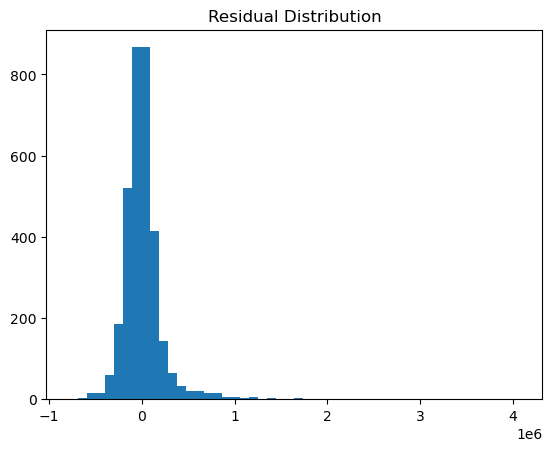

In [18]:
residuals = y_val - y_pred_tab

plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_val, y_pred_tab)
print("mean absolute error(tab) : ",mae)

mean absolute error(tab) :  132817.61161405742


### Model [B]

In [21]:
image_features = [col for col in train_df.columns if col not in tabular_features + ["id", "price"]]

X_img = train_df[image_features].select_dtypes(include=["number"])
X_tab = train_df[tabular_features].select_dtypes(include=["number"])
X_multi = np.hstack([
    scaler.fit_transform(X_tab),
    X_img.values
])


In [22]:
print("X_tab shape:", X_tab.shape)
print("X_img shape:", X_img.shape)
print("X_img dtypes:\n", X_img.dtypes.value_counts())


X_tab shape: (16405, 15)
X_img shape: (16405, 515)
X_img dtypes:
 float32    512
int64        3
Name: count, dtype: int64


In [23]:
X_train_m, X_val_m, y_train, y_val = train_test_split(
    X_multi, y, test_size=0.2, random_state=42
)


In [24]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_m, y_train)
y_pred_multi = rf.predict(X_val_m)

# Metrics
rmse_multi = np.sqrt(mean_squared_error(y_val, y_pred_multi))
r2_multi = r2_score(y_val, y_pred_multi)

print("MULTIMODAL RMSE:", rmse_multi)
print("MULTIMODAL R²:", r2_multi)


MULTIMODAL RMSE: 154088.3965851403
MULTIMODAL R²: 0.8287905960383224


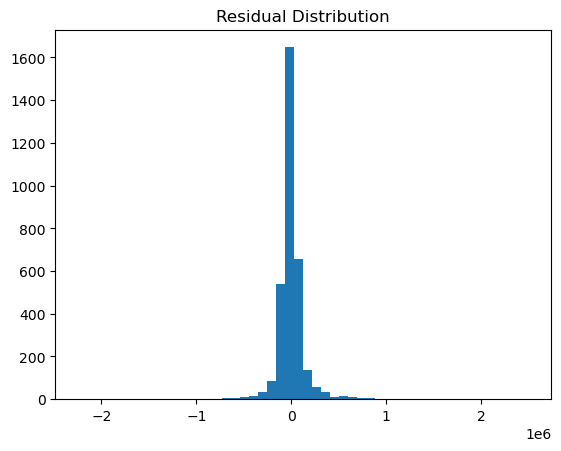

In [25]:
residuals = y_val - y_pred_multi

plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_val, y_pred_multi)
print("mean absolute error(multi) : ",mae)

mean absolute error(multi) :  82031.51801022088


## Explainability with Grad-CAM




In [29]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
# import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)
resnet = resnet.to(device)
resnet.eval()


C:\Users\mohit\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mohit\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
target_layer = resnet.layer4[-1]


In [32]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        output = self.model(input_tensor)
        score = output.mean()  # regression proxy
        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.squeeze().detach().cpu().numpy()


In [33]:
from torchvision import transforms

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    tensor = img_transform(img).unsqueeze(0).to(device)
    return img, tensor


In [34]:
gradcam = GradCAM(resnet, target_layer)

# Pick ANY image (prefer expensive & cheap examples)
sample_id = train_df.sample(1)["id"].values[0]
img_path = f"../data/images/train/{sample_id}.png"

original_img, input_tensor = load_image(img_path)
cam = gradcam.generate(input_tensor)


C:\Users\mohit\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


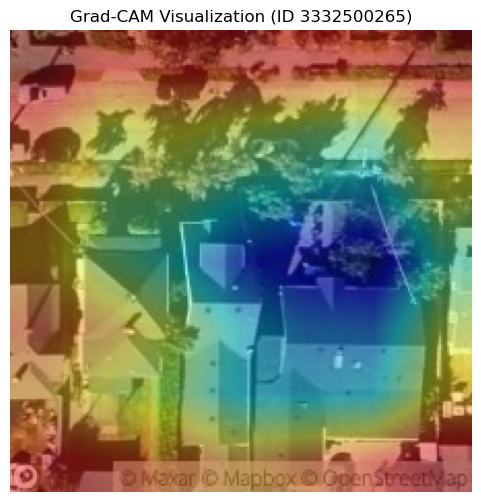

In [35]:
def overlay_cam(img, cam):
    img = np.array(img)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return overlay

overlay = overlay_cam(original_img, cam)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Grad-CAM Visualization (ID {sample_id})")
plt.show()


## Final Predictions

In [41]:
tabular_features = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement", "lat", "long",
    "sqft_living15", "sqft_lot15"
]

image_features = [col for col in test_df.columns if col not in tabular_features + ["id", "price"]]

X_test_img = test_df[image_features].select_dtypes(include=["number"])
X_test_tab = test_df[tabular_features].select_dtypes(include=["number"])

X_test_multi = np.hstack([
    scaler.transform(X_test_tab),   # NOTE: transform, not fit
    X_test_img.values
])



In [43]:
test_predictions = rf.predict(X_test_multi)
pred_df = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_predictions
})

pred_df.head()


,id,predicted_price
0,2591820310,4.252149e+05
1,7974200820,8.197827e+05
2,7701450110,1.105900e+06
3,9522300010,2.312221e+06
4,9510861140,8.035530e+05


In [44]:
print("Rows in test_df:", len(test_df))
print("Predictions:", len(test_predictions))
print(pred_df.describe())


Rows in test_df: 5409
Predictions: 5409
                 id  predicted_price
count  5.409000e+03     5.409000e+03
mean   4.600535e+09     5.476438e+05
std    2.883657e+09     3.419756e+05
min    1.000102e+06     1.458376e+05
25%    2.125059e+09     3.357795e+05
50%    3.904931e+09     4.608593e+05
75%    7.345310e+09     6.492898e+05
max    9.842300e+09     4.445308e+06


In [45]:
pred_df.to_csv("predictions.csv", index=False)
